In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
import keras
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [67]:
%run utils.py

In [68]:
%run models.py

In [69]:
%%time

image_size = 28
frame_duration = 1.0
overlap = 0.5
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

Generating training data...
CPU times: user 23.4 s, sys: 3.14 s, total: 26.5 sing 66/117Interpolating 106/117Interpolating 1/112Interpolating 29/112Interpolating 96/112Interpolating 1/111Interpolating 52/111Interpolating 99/111Interpolating 1/109Interpolating 53/109Interpolating 100/109Interpolating 1/113Interpolating 24/113Interpolating 71/113Interpolating 1/104Interpolating 54/104Interpolating 91/104Interpolating 1/101Interpolating 41/101Interpolating 92/101Interpolating 1/102Interpolating 46/102Interpolating 59/102Interpolating 95/102Interpolating 1/107Interpolating 26/107Interpolating 69/107Interpolating 1/113Interpolating 50/113Interpolating 1/115Interpolating 58/115Interpolating 110/115Interpolating 1/139Interpolating 58/139Interpolating 108/139Interpolating 1/123Interpolating 42/123Interpolating 83/123Interpolating 1/118Interpolating 58/118Interpolating 103/118Interpolating 1/120Interpolating 58/120Interpolating 111/120Interpolating 1/117Interpolating 56/117Interpolating 108/117

In [70]:
X.shape, y.shape

((1821, 28, 28, 3), (1821,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


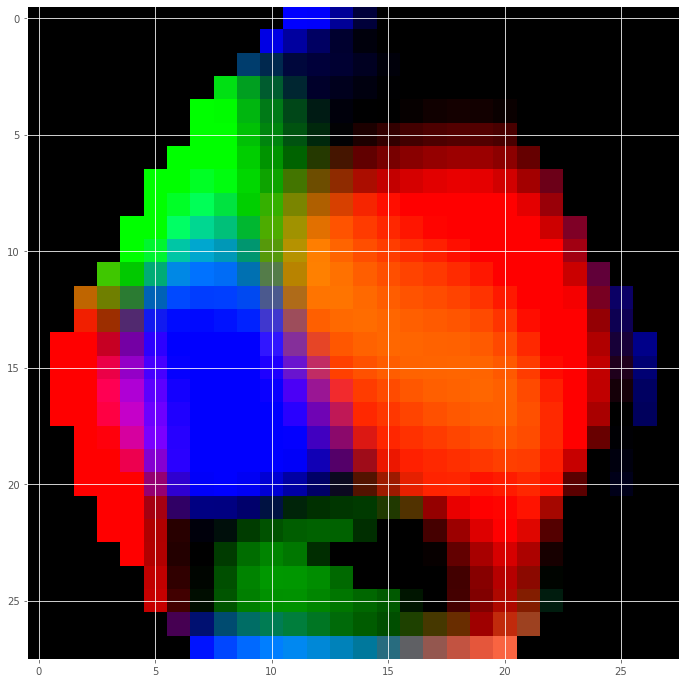

In [71]:
plt.imshow(X[3])

In [72]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)

In [73]:
y_train.shape

(1456,)

In [74]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (1456, 28, 28, 3)
1456 train samples
365 test samples


### Train Original Model

In [81]:
batch_size = 32
num_classes = 2
epochs = 200

# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)


model = get_func_model_1(input_shape, num_classes)
# model = get_model_2(input_shape, num_classes)


# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255

In [84]:
class CamCallback(tf.keras.callbacks.Callback):
    
    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs):
        cam_n, heatmap_n = naive_cam(self.model, X)
        y_pred = self.model.predict(X)
        y_pred = np.argmax(y_pred, axis=1)
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        loss = logs['loss']
        epochs_data.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'loss': loss,
            'attention': heatmap_n.tolist()
        })
        print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, Loss: {loss}')
        
        
epochs_data = []


In [85]:
%%time

history =   model.fit(x_train, y_train_cat,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test_cat),
            shuffle=True,
            verbose=1,
            callbacks=[CamCallback()])

Train on 1456 samples, validate on 365 samples
Epoch 1/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.6894 - acc: 0.5467 - val_loss: 0.6869 - val_acc: 0.5425
Accuracy: 0.5584843492586491, Precision: 0.6011787819253438, Recall: 0.33737596471885334, Loss: 0.6894383129182753
Epoch 2/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.6826 - acc: 0.5536 - val_loss: 0.6917 - val_acc: 0.5397
Accuracy: 0.5683690280065898, Precision: 0.5630865484880083, Recall: 0.5953693495038589, Loss: 0.6825929624693734
Epoch 3/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.6777 - acc: 0.5666 - val_loss: 0.6900 - val_acc: 0.5479
Accuracy: 0.5963756177924218, Precision: 0.6197771587743732, Recall: 0.4906284454244763, Loss: 0.6777151770644135
Epoch 4/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.6669 - acc: 0.6085 - val_loss: 0.6913 - val_acc: 0.5562
Accuracy: 0.6188907193849533, Precision: 0.5996258185219832, Recall: 0

1456/1456 [==============================] - 2s 1ms/step - loss: 0.5211 - acc: 0.7548 - val_loss: 0.6580 - val_acc: 0.6466
Accuracy: 0.7446457990115322, Precision: 0.7012750455373407, Recall: 0.8489525909592062, Loss: 0.5210553859616374
Epoch 35/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.5124 - acc: 0.7617 - val_loss: 0.6587 - val_acc: 0.6575
Accuracy: 0.7495881383855024, Precision: 0.7149666348903718, Recall: 0.8269018743109151, Loss: 0.512360760143825
Epoch 36/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.5073 - acc: 0.7569 - val_loss: 0.6851 - val_acc: 0.6274
Accuracy: 0.729818780889621, Precision: 0.8139183055975794, Recall: 0.5931642778390298, Loss: 0.5072563932492182
Epoch 37/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.5032 - acc: 0.7768 - val_loss: 0.6609 - val_acc: 0.6685
Accuracy: 0.7556287753981329, Precision: 0.7204198473282443, Recall: 0.8324145534729879, Loss: 0.5032031116904793
Epoch 38/200
14

1456/1456 [==============================] - 2s 1ms/step - loss: 0.4136 - acc: 0.8242 - val_loss: 0.6362 - val_acc: 0.6877
Accuracy: 0.8176825919824272, Precision: 0.8176795580110497, Recall: 0.8158765159867696, Loss: 0.4135820053435944
Epoch 68/200
1456/1456 [==============================] - 4s 3ms/step - loss: 0.4049 - acc: 0.8262 - val_loss: 0.6473 - val_acc: 0.6904
Accuracy: 0.8132894014277869, Precision: 0.7968586387434555, Recall: 0.8390297684674752, Loss: 0.4048833309949099
Epoch 69/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.4048 - acc: 0.8372 - val_loss: 0.6439 - val_acc: 0.6712
Accuracy: 0.7902251510159253, Precision: 0.7354260089686099, Recall: 0.9040793825799338, Loss: 0.40476426809698673
Epoch 70/200
1456/1456 [==============================] - 3s 2ms/step - loss: 0.4012 - acc: 0.8283 - val_loss: 0.6422 - val_acc: 0.6849
Accuracy: 0.8099945085118067, Precision: 0.7694524495677233, Recall: 0.8831312017640573, Loss: 0.40115221254118194
Epoch 71/20

1456/1456 [==============================] - 2s 1ms/step - loss: 0.3260 - acc: 0.8819 - val_loss: 0.6784 - val_acc: 0.6932
Accuracy: 0.8336079077429983, Precision: 0.7785977859778598, Recall: 0.9305402425578831, Loss: 0.32601562993867056
Epoch 101/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.3261 - acc: 0.8668 - val_loss: 0.6711 - val_acc: 0.6795
Accuracy: 0.8484349258649094, Precision: 0.8760429082240763, Recall: 0.8103638368246968, Loss: 0.32609827669112235
Epoch 102/200
1456/1456 [==============================] - 3s 2ms/step - loss: 0.3169 - acc: 0.8777 - val_loss: 0.6868 - val_acc: 0.6685
Accuracy: 0.8358045030203185, Precision: 0.8680387409200968, Recall: 0.7905181918412348, Loss: 0.3169465657773909
Epoch 103/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.3245 - acc: 0.8805 - val_loss: 0.6917 - val_acc: 0.6822
Accuracy: 0.8385502471169687, Precision: 0.8037661050545094, Recall: 0.8941565600882029, Loss: 0.3245068682091577
Epoch 10

1456/1456 [==============================] - 2s 1ms/step - loss: 0.2591 - acc: 0.9052 - val_loss: 0.7094 - val_acc: 0.6795
Accuracy: 0.8725974739154311, Precision: 0.8511966701352758, Recall: 0.9018743109151047, Loss: 0.25914768629021695
Epoch 134/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.2584 - acc: 0.9128 - val_loss: 0.7964 - val_acc: 0.6877
Accuracy: 0.8028555738605162, Precision: 0.7279534109816972, Recall: 0.9647188533627343, Loss: 0.2583527905600412
Epoch 135/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.2547 - acc: 0.9052 - val_loss: 0.7497 - val_acc: 0.6849
Accuracy: 0.85612300933553, Precision: 0.8134110787172012, Recall: 0.9228224917309813, Loss: 0.25467484370692745
Epoch 136/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.2550 - acc: 0.9107 - val_loss: 0.7704 - val_acc: 0.6932
Accuracy: 0.8544755628775398, Precision: 0.9268617021276596, Recall: 0.7684674751929438, Loss: 0.25496520265773104
Epoch 137

1456/1456 [==============================] - 2s 1ms/step - loss: 0.2074 - acc: 0.9306 - val_loss: 0.8039 - val_acc: 0.6904
Accuracy: 0.8704008786381109, Precision: 0.8198284080076264, Recall: 0.948180815876516, Loss: 0.20740025646083957
Epoch 167/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.2149 - acc: 0.9210 - val_loss: 0.7535 - val_acc: 0.6877
Accuracy: 0.8956617243272927, Precision: 0.8826040554962646, Recall: 0.9117971334068358, Loss: 0.2149482678908568
Epoch 168/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.2022 - acc: 0.9341 - val_loss: 0.9195 - val_acc: 0.6822
Accuracy: 0.8308621636463481, Precision: 0.9558599695585996, Recall: 0.6923925027563396, Loss: 0.20219557822405637
Epoch 169/200
1456/1456 [==============================] - 3s 2ms/step - loss: 0.2051 - acc: 0.9348 - val_loss: 0.7863 - val_acc: 0.6822
Accuracy: 0.8907193849533224, Precision: 0.890728476821192, Recall: 0.8897464167585446, Loss: 0.20512822172143957
Epoch 170

1456/1456 [==============================] - 2s 1ms/step - loss: 0.1651 - acc: 0.9478 - val_loss: 0.8622 - val_acc: 0.7041
Accuracy: 0.8802855573860516, Precision: 0.8302972195589645, Recall: 0.9547960308710033, Loss: 0.16506276631748285
Epoch 200/200
1456/1456 [==============================] - 2s 2ms/step - loss: 0.1689 - acc: 0.9451 - val_loss: 0.8728 - val_acc: 0.6932
Accuracy: 0.9088412959912137, Precision: 0.9234285714285714, Recall: 0.8908489525909592, Loss: 0.16890989194859515
CPU times: user 16min 43s, sys: 55.3 s, total: 17min 38s
Wall time: 14min 43s


In [88]:
import json
with open('../proyecto-insideout/data/data-by-epoch.json', 'w') as file:
    json.dump(epochs_data, file)

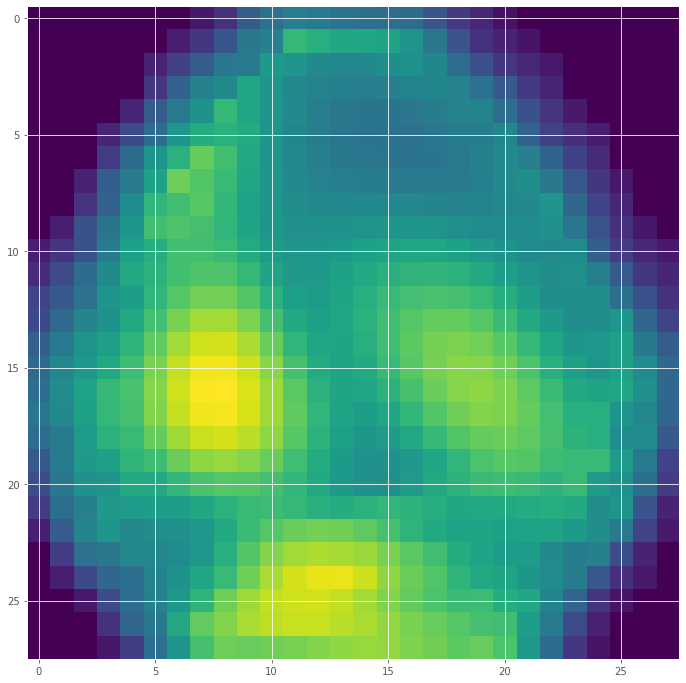

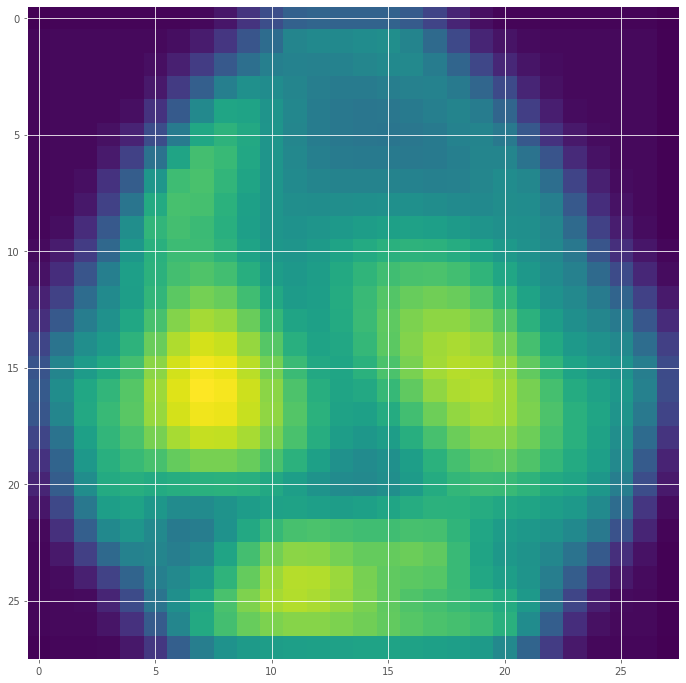

In [65]:
plt.imshow(epochs_heatmaps[0])
plt.show()
plt.imshow(epochs_heatmaps[199])
plt.show()

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                62730     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total para

In [13]:
model.layers

In [18]:
model.save('models/model_2.h5')

In [19]:
predictions_base_model = model.predict(X)
predictions_base_model.shape

(1821, 2)

In [20]:
predictions_base_model

array([[3.4503936e-04, 9.9965501e-01],
       [2.1045016e-02, 9.7895491e-01],
       [1.7873488e-03, 9.9821270e-01],
       ...,
       [8.9528030e-01, 1.0471968e-01],
       [8.7062722e-01, 1.2937282e-01],
       [6.5833932e-01, 3.4166068e-01]], dtype=float32)

### CAM 2.0

In [9]:
import tensorflow as tf
import keras.backend as K
from keras.layers.core import Lambda
from keras.models import Sequential
import numpy as np
from keras.models import load_model
 


In [11]:
# load model
model = load_model('models/model_2.h5')

In [76]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def naive_cam(input_model, images):
    conv_output = model.layers[2].output 
    cam_extractor = K.function([model.input], [conv_output])
    cam = cam_extractor([images])
    cam = cam[0]
    cam = np.maximum(cam, 0)
    cam = np.mean(cam, axis=3)
    cam = np.mean(cam, axis=0)
    heatmap = cam / np.max(cam)
    return cam, heatmap

def grad_cam(input_model, image, category_index, layer_name):
    nb_classes = 2
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    last = Lambda(target_layer, output_shape=target_category_loss_output_shape)(input_model.output)
    model = Model(inputs=input_model.input, outputs=last)
    loss = K.sum(model.layers[-1].output)
    conv_output = model.layers[2].output  
    grads = normalize(K.gradients(loss, conv_output)[0])
    
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])
    
    output, grads_val = gradient_function([image[None]])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    return cam, heatmap

In [30]:
cam_n, heatmap_n = naive_cam(model, X, 'conv2d_2')

(1821, 28, 28)
(28, 28)


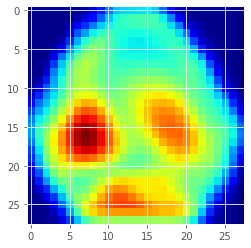

In [31]:
plt.imshow(heatmap_n, cmap='jet')
plt.show()

(1, 28, 28, 32)


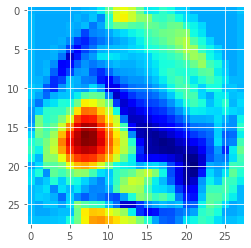

In [41]:
predictions = model.predict(X)
predicted_class = np.argmax(predictions[0])
cam, heatmap = grad_cam(model, X[0], predicted_class, 'conv2d_2')
plt.imshow(cam, cmap='jet')
plt.show()

## Visualize CAMs

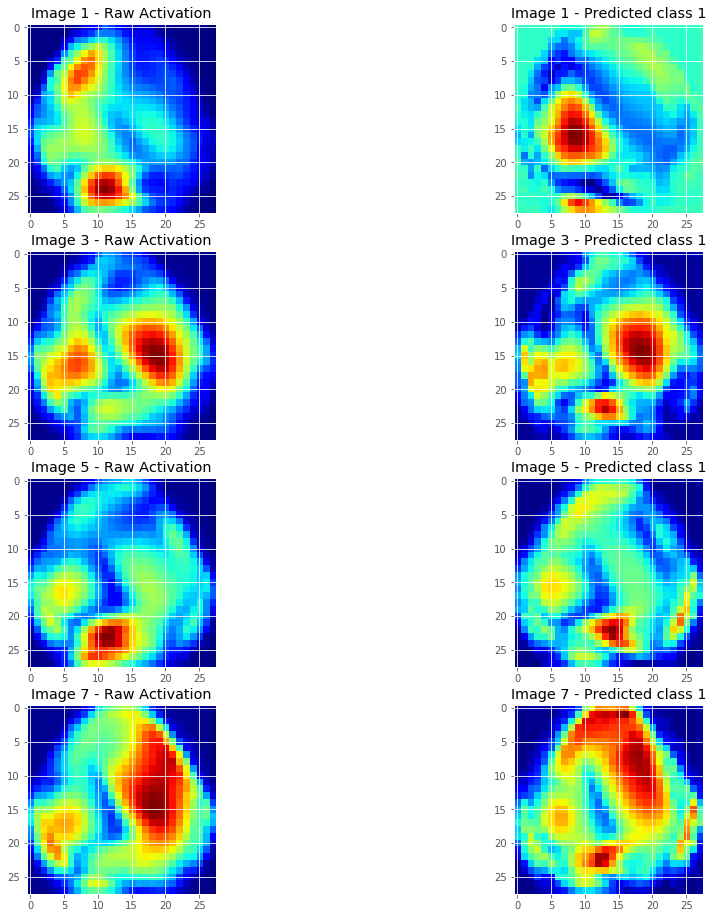

In [51]:
    
fig= plt.figure(figsize=(16, 16))
columns = 2
rows = 4
for i in range(1, columns * rows + 1, columns):
    #cam0, heatmap0 = grad_cam(model, X[i], 0, 'conv2d_2')
    #fig.add_subplot(rows, columns, i)
    #plt.imshow(cam0, cmap='jet')
    #plt.title(f'Image {i} - class {0}')
    
    cam_n, heatmap_n = naive_cam(model, X[i], 0, 'conv2d_2')
    fig.add_subplot(rows, columns, i)
    plt.imshow(cam_n, cmap='jet')
    plt.title(f'Image {i} - Raw Activation')
    
    predicted_class = np.argmax(predictions[0])
    
    cam1, heatmap1 = grad_cam(model, X[i], predicted_class, 'conv2d_2')
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(cam1, cmap='jet')
    plt.title(f'Image {i} - Predicted class {predicted_class}')
    
plt.show()